In [33]:
'''Googleドライブマウント'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# ライブラリのインポート
import random
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
import torchvision.utils as vutils

import os

# ランダムシード
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [35]:
'''MNISTデータセットをダウンロード'''

from sklearn.datasets import fetch_openml

# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# フォルダ「data」の下にフォルダ「img_78」を作成する
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

mnist = fetch_openml('mnist_784', version=1, data_home="./", as_frame=False)

# データの取り出し
X = mnist.data
y = mnist.target

# MNISTから数字7、8の画像だけフォルダ「img_78」に画像として保存していく
count7=0
count8=0
max_num=200  # 画像は200枚ずつ作成する

for i in range(len(X)):
    
    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count7+=1 
    
    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count8+=1 

In [36]:
'''デバイスの設定'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
'''初期設定'''

dir_path = "/content/drive/My Drive/Colab Notebooks/DCGAN/result"
os.makedirs(dir_path, exist_ok=True)

model_name = "DCGAN"
f_path_result = f"/content/drive/My Drive/Colab Notebooks/DCGAN/result/{model_name}"
f_path_params = f"/content/drive/My Drive/Colab Notebooks/DCGAN/params/{model_name}"

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

image_size = 64

In [38]:
'''ハイパーパラメータの設定'''

import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--num_epochs", type=int, default=200)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr_g", type=float, default=1e-4)
parser.add_argument("--lr_d", type=float, default=4e-4)
parser.add_argument("--nch_g", type=int, default=128) # 生成器のチャネル数
parser.add_argument("--nch_d", type=int, default=128) # 識別器のチャネル数
parser.add_argument("--z_dim", type=int, default=20) # ノイズの次元
parser.add_argument("--beta1", type=float, default=0.0) # Adamのハイパーパラメータ
parser.add_argument("--beta2", type=float, default=0.9) # Adamのハイパーパラメータ
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, beta1=0.0, beta2=0.9, lr_d=0.0004, lr_g=0.0001, nch_d=128, nch_g=128, num_epochs=200, z_dim=20)


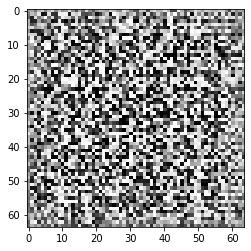

In [39]:
'''Generatorの実装'''

class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

# 動作確認
G = Generator(z_dim=opt.z_dim, image_size=image_size)

input_z = torch.randn(1, 20) # 入力する乱数
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1) # テンソルサイズを(1, 20, 1, 1)に変形
fake_images = G(input_z) # 偽画像を出力
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [40]:
'''Discriminatorの実装'''

class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

# 動作確認
D = Discriminator(z_dim=opt.z_dim, image_size=image_size)
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z) # 偽画像を生成
d_out = D(fake_images) # 偽画像をDに入力
print(nn.Sigmoid()(d_out)) # 出力d_outにSigmoidをかけて0から1に変換

tensor([[[[0.5066]]]], grad_fn=<SigmoidBackward0>)


In [41]:
'''DataLoaderの実装'''

def make_datapath_list():
    
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成"""

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


class ImageTransform():
    
    """画像の前処理クラス"""
    
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
    
    
class GAN_Img_Dataset(data.Dataset):
    
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        
        """画像の枚数を返す"""
        return len(self.file_list)

    def __getitem__(self, index):
        
        """前処理をした画像のTensor形式のデータを取得"""

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


# DataLoaderの作成と動作確認
train_img_list=make_datapath_list() # ファイルリストを作成

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=opt.batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])

'''ネットワークの初期化'''

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

torch.Size([64, 1, 64, 64])
ネットワークの初期化完了


In [42]:
'''ネットワークの初期化'''

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [43]:
'''損失関数と最適化関数の定義'''

# 誤差関数を定義
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 最適化手法の設定
optimizerG = torch.optim.Adam(G.parameters(), opt.lr_g, [opt.beta1, opt.beta2])
optimizerD = torch.optim.Adam(D.parameters(), opt.lr_g, [opt.beta1, opt.beta2])

In [44]:
'''パラメータを保存する関数の定義'''

def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + "/g_{:04d}.pth".format(epoch)
    )

    torch.save(
        netD.state_dict(),
        file_path + "/d_{:04d}.pth".format(epoch)
    )

In [45]:
'''学習'''

lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []

def train_model(G, D, dataloader, num_epochs):
    
    # パラメータをハードコーディング
    mini_batch_size = opt.batch_size

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imgs in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            # issue #186より不要なのでコメントアウト
            # if imgs.size()[0] == 1:
            #     continue

            # GPUが使えるならGPUにデータを送る
            imgs = imgs.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imgs.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real = D(imgs)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, opt.z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            optimizerG.zero_grad()
            optimizerD.zero_grad()

            d_loss.backward()
            optimizerD.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, opt.z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            optimizerG.zero_grad()
            optimizerD.zero_grad()
            g_loss.backward()
            optimizerG.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            raw_lossesD.append(epoch_d_loss)
            raw_lossesG.append(epoch_g_loss)
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f}'.format(
            epoch+1, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        lossesD.append(epoch_d_loss/batch_size)
        lossesG.append(epoch_g_loss/batch_size)
        
        vutils.save_image(fake_images, f_path_result + f"/{epoch+1}.jpg")
        save_params(f_path_params, epoch, D, G)

    return G, D


# 学習・検証を実行する
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=opt.num_epochs)


-------------
Epoch 1/200
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.1339 || Epoch_G_Loss:0.0729
timer:  1.8367 sec.
-------------
Epoch 2/200
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0911 || Epoch_G_Loss:0.0805
timer:  1.8028 sec.
-------------
Epoch 3/200
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0874 || Epoch_G_Loss:0.0932
timer:  1.8118 sec.
-------------
Epoch 4/200
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0658 || Epoch_G_Loss:0.1281
timer:  1.7807 sec.
-------------
Epoch 5/200
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0300 || Epoch_G_Loss:0.1987
timer:  1.8025 sec.
-------------
Epoch 6/200
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0684 || Epoch_G_Loss:0.1716
timer:  1.8680 sec.
-------------
Epoch 7/200
-------------
（train）
-------------
epoch 7 || Epoch_D_Loss:0.0261 || Epoch_G_Loss:0.2168
timer:  1.8150 sec.
-------------
Epoch 8/200
-------------
（train）


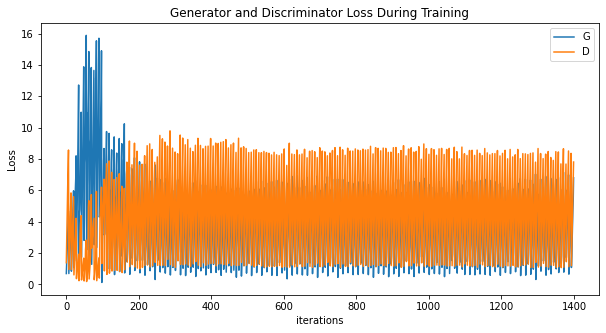

In [46]:
'''訓練イテレーションごとの損失'''

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(raw_lossesG,label="G")
plt.plot(raw_lossesD,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

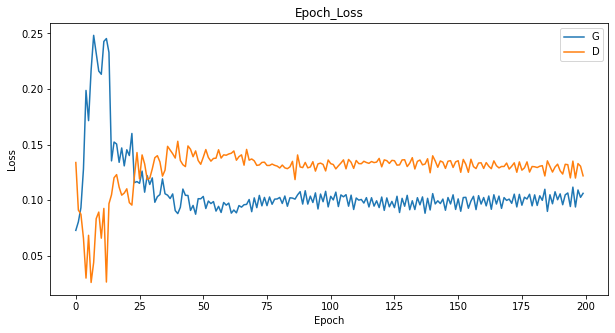

In [47]:
'''エポックごとの損失'''

plt.figure(figsize=(10,5))
plt.title("Epoch_Loss")
plt.plot(lossesG,label="G")
plt.plot(lossesD,label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

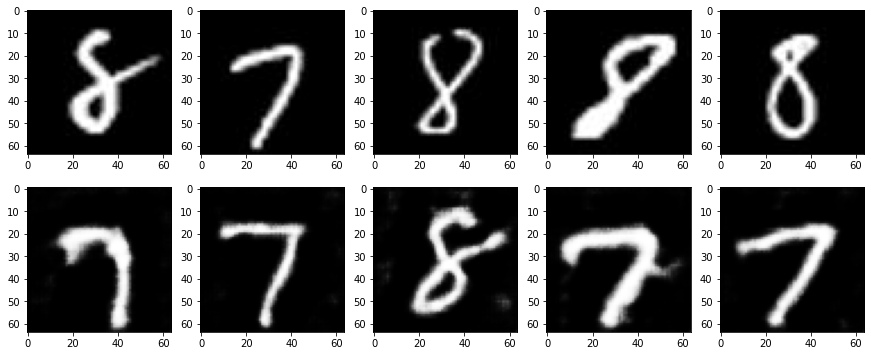

In [50]:
'''生成画像と訓練データを可視化'''

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')